In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modeling 

1. Give "Top Tier User Scores" 
2. Model Linear Regression Model 
3. Four Actionable Items 

## Features 

1. Percentage of Total Views within last week 
2. Complete and Mature Profile (complete profile and has pitch deck)
3. Metric Card User 
4. Active within past 30 days 

Other features 
1. Days from signup to last update 
2. amount raised  

## Our Data

In [5]:
op_analytics = pd.read_csv("onepager_analytics.csv") #percentage total views 
founders = pd.read_csv("founders.csv") #complete/mature
op_founders = pd.read_csv("onepager_founders.csv") #complete/mature
onepager = pd.read_csv("onepagers.csv") #complete/mature 
traction = pd.read_csv("onepager_traction_and_performance.csv") #metric card 

### 1. Percentage of Total Views 

In [6]:
# 844 unique onepagers, but over 60000 interactions 
op_analytics.head()

,uuid,onepager_uuid,fetch_date,total_views,unique_views,bounce_rate,created_at,updated_at
0,00012682-0e23-4efe-8a4b-8ab30115844c,01ac3f85-0549-4cde-b57c-8ba7ba62c006,2021-03-09 00:00:00,0,0,0.0,2021-03-09 08:52:30,2021-03-20 09:00:06
1,00028bff-80cb-4116-9603-a59bb6b1edf8,c4dcf7f9-e88a-4738-94c0-a203e6101df0,2020-11-13 00:00:00,4,3,0.0,2020-11-13 08:52:56,2021-01-18 09:27:07
2,00028dd5-75ff-4d9a-bc3d-6f53e1ac6ed9,fda32462-2923-4965-88b6-9cb5394f4225,2020-11-20 00:00:00,0,0,0.0,2020-11-20 10:55:05,2021-01-01 12:55:44
3,00036a27-ef92-4f88-98ce-cdd90e7ed009,4dcbf3df-f55e-46ad-902c-f05bbf7926b0,2021-02-20 00:00:00,0,0,0.0,2021-02-20 08:52:59,2021-03-20 09:17:13
4,0004b827-0fda-4459-97b1-3fc61ff29d54,77690cf9-3292-4424-a1db-5e9f229f8af6,2020-11-04 00:00:00,0,0,0.0,2020-11-04 08:52:35,2021-01-29 09:25:35


In [7]:
# merging and cleaning 
pct_ttl_views = op_analytics.sort_values("total_views", ascending = False)
pct_ttl_views = pd.merge(pct_ttl_views, op_founders, how = "left", left_on = "onepager_uuid", right_on = "onepager_uuid")
pct_ttl_views = pct_ttl_views[["founder_uuid", "onepager_uuid", "total_views", "bounce_rate"]]

# filtering and manipulation 
filtered = pct_ttl_views[(pct_ttl_views['bounce_rate']<100) & (pct_ttl_views['bounce_rate']>0)]
total_views = sum(filtered['total_views'])
filtered['percentage_total'] = filtered[['total_views']]/total_views
filtered = filtered[["founder_uuid", "percentage_total"]]
filtered = filtered.groupby("founder_uuid").sum().reset_index()
#filtered

<ipython-input-7-166bd1601399>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['percentage_total'] = filtered[['total_views']]/total_views


**Improvement for this week:** Look into percentage total views for the **past week**! That way we account for the recency factor of what defines "top tier user" 

### 2. Complete and Mature Profile

In [8]:
# left join founders and op_founders 
founder_onepager = pd.merge(founders, op_founders, how = "left", left_on = "uuid", right_on = "founder_uuid").drop(columns = {"founder_uuid","created_at_y", "updated_at_y"})

In [9]:
complete_profiles = founders.copy().dropna()["uuid"] #profile all completed
founder_onepager["has complete profile"] = founder_onepager["uuid"].isin(complete_profiles.tolist())
print("Founders with complete profiles: ", len(complete_profiles))

mature_profiles = onepager.copy().dropna(subset = ["pdf_filename"]) #pitch deck
mature_profiles = pd.merge(mature_profiles, op_founders, how = "left", left_on = "uuid", right_on = "onepager_uuid")["founder_uuid"]
founder_onepager["has mature onepager"] = founder_onepager["uuid"].isin(mature_profiles.tolist())
print("Founders with pitch decks: ", len(mature_profiles))

founder_onepager["complete and mature"] = (founder_onepager['has complete profile'] == True) & (founder_onepager['has mature onepager'] == True)
filtered_2 = founder_onepager[["uuid", "complete and mature"]]
filtered_2.head()

Founders with complete profiles:  2046
Founders with pitch decks:  1769


,uuid,complete and mature
0,0011279a-0c95-4f3d-8ae0-a0916fe54afd,False
1,0014bb20-d843-42f5-8af4-d30de649e1f9,True
2,0026b115-ef03-4a6d-a474-cc6e98672232,False
3,004a3eee-e647-4495-bc42-a7e588acb32d,True
4,004d7015-53dd-4f0d-81f6-a33e53ee537c,False


In [10]:
#merging "percentage view" with "complete and mature"
final = pd.merge(filtered_2, filtered, how = "outer", left_on = "uuid", right_on = "founder_uuid").drop(columns = {"founder_uuid"}).fillna(0)
final.head()

,uuid,complete and mature,percentage_total
0,0011279a-0c95-4f3d-8ae0-a0916fe54afd,False,0.000000
1,0014bb20-d843-42f5-8af4-d30de649e1f9,True,0.000000
2,0026b115-ef03-4a6d-a474-cc6e98672232,False,0.000000
3,004a3eee-e647-4495-bc42-a7e588acb32d,True,0.000788
4,004d7015-53dd-4f0d-81f6-a33e53ee537c,False,0.000000


### 3. Metric Card User

In [11]:
traction.head()

,uuid,onepager_uuid,acronym,parent_metric,sub_metric,time_period,metric_value,prefix,suffix,order,created_at,updated_at
0,01dc18cc-fc13-47c4-a4ab-0acb49bab331,2141b6b9-d0b0-4c0f-b8db-50dbe5c5069d,RTN,Revenue and Sales,Total Addressable Market,NaN,1.400000e+13,$,NaN,1,2021-02-27 03:53:57,2021-02-27 03:53:57
1,02940790-1992-4fcc-800d-fdbde2a06a7f,94f69d52-b733-40d5-932d-a91d7ecc382d,URM,Users,User Retention,per month,7.000000e+01,NaN,%,5,2021-02-21 21:17:24,2021-03-12 09:24:48
2,02b0505e-cc3b-4a23-9812-c59425013638,22f04020-b76b-45e0-a197-94c6aba7a71b,CNLM,Customer Value,Net Promoter Score,last month,9.800000e+00,NaN,NaN,1,2021-01-29 21:19:44,2021-01-29 21:20:59
3,02b0bb33-c899-4e2f-9149-daba45c22464,a079e0bd-7dc2-4cef-99c8-33d639ffa35d,URW,Users,User Retention,per week,9.100000e+00,NaN,%,2,2021-03-16 01:10:16,2021-03-19 06:34:43
4,03c5f718-a4e6-40e5-9d79-23f47ab21db0,5c6f9f14-9028-4d62-b8a8-6b16dee3f5e1,RRM,Revenue and Sales,Recurring Revenue,per month,4.200000e+03,$,NaN,1,2021-02-23 11:56:57,2021-03-02 15:01:13


In [12]:
# minimal data but better than last week with only 215 
print("number of metric card users:", traction.shape[0])

number of metric card users: 343


In [13]:
# after 2/17 w/ introduction of metrics card 
traction["created_at"] = traction["created_at"].str.extract(r'(\d{4}-0(2|3)-\d{2})')
traction = traction.sort_values("created_at", ascending = True)

after_mcard = traction.dropna(subset = ["created_at"])
founders_w_mcard = after_mcard["onepager_uuid"]

# added "has metric card" column to founder_onepager
founder_onepager["has metric card"] = founder_onepager["onepager_uuid"].isin(founders_w_mcard.tolist())

# made cleaned table filtered_3 
filtered_3 = founder_onepager[["uuid", "has metric card"]]
filtered_3.head()

,uuid,has metric card
0,0011279a-0c95-4f3d-8ae0-a0916fe54afd,False
1,0014bb20-d843-42f5-8af4-d30de649e1f9,False
2,0026b115-ef03-4a6d-a474-cc6e98672232,False
3,004a3eee-e647-4495-bc42-a7e588acb32d,False
4,004d7015-53dd-4f0d-81f6-a33e53ee537c,False


In [14]:
# merging filtered_3 into final 
final = pd.merge(final, filtered_3, how = "left", left_on = "uuid", right_on = "uuid")
final.head()

,uuid,complete and mature,percentage_total,has metric card
0,0011279a-0c95-4f3d-8ae0-a0916fe54afd,False,0.000000,False
1,0014bb20-d843-42f5-8af4-d30de649e1f9,True,0.000000,False
2,0026b115-ef03-4a6d-a474-cc6e98672232,False,0.000000,False
3,004a3eee-e647-4495-bc42-a7e588acb32d,True,0.000788,False
4,004d7015-53dd-4f0d-81f6-a33e53ee537c,False,0.000000,False


### 4. Active within past week 

Active 3/10 - 3/20 

In [15]:
# a lil bit of data cleaning first! keeping only data past 2/5
founder_onepager = founder_onepager.rename(columns = {"created_at_x": "created_at", "updated_at_x": "updated_at"})
founder_onepager["created_at"] = founder_onepager["created_at"].str.extract(r'(\d{4}-\d{2}-\d{2})')
founder_onepager["updated_at"] = founder_onepager["updated_at"].str.extract(r'(\d{4}-\d{2}-\d{2})')

recent_update = founder_onepager.copy() 
recent_update["updated_at"] = recent_update["updated_at"].str.extract(r'(\d{4}-03-1\d)')
recent_update = recent_update.sort_values("updated_at", ascending = False)
recent_update = recent_update.dropna(subset = ["updated_at"])
print("number of new users/recent updates:", recent_update.shape[0])
# #recent_update.head()

number of new users/recent updates: 814


In [16]:
# filter out new users (defined to be those who created onepager on 3/5)
new_user_index = sum([date == '2021-03-20' for date in recent_update["created_at"].tolist()])
recent_update = recent_update.iloc[new_user_index:]
print("number of users who's creation and update are different:", sum(recent_update["created_at"] != recent_update["updated_at"]))
print("number of users who's creation and update are the same:", sum(recent_update["created_at"] == recent_update["updated_at"]))

number of users who's creation and update are different: 494
number of users who's creation and update are the same: 320


In [17]:
# made new table filtered_4
founder_onepager["updated past week"] = founder_onepager['uuid'].isin(recent_update["uuid"])

filtered_4 = founder_onepager[["uuid", "updated past week"]]
filtered_4.head()

,uuid,updated past week
0,0011279a-0c95-4f3d-8ae0-a0916fe54afd,False
1,0014bb20-d843-42f5-8af4-d30de649e1f9,False
2,0026b115-ef03-4a6d-a474-cc6e98672232,True
3,004a3eee-e647-4495-bc42-a7e588acb32d,False
4,004d7015-53dd-4f0d-81f6-a33e53ee537c,False


In [18]:
final = pd.merge(final, filtered_4, how = "left", left_on = "uuid", right_on = "uuid").drop(columns = "uuid")

In [19]:
final

,complete and mature,percentage_total,has metric card,updated past week
0,False,0.000000,False,False
1,True,0.000000,False,False
2,False,0.000000,False,True
3,True,0.000788,False,False
4,False,0.000000,False,False
...,...,...,...,...
3337,True,0.000272,False,True
3338,True,0.001304,False,False
3339,True,0.000272,False,False
3340,False,0.000516,False,False


## Top Tier User Score 

gave arbitrary weights 

In [64]:
def scoring(df):
    score = [0] * 3342 
    w1 = 0.25
    w2 = 0.05
    w3 = 0.25
    w4 = 0.45
    
    for row in np.arange(3342):
        for col in np.arange(0,4):
            if col == 0:
                if df.iloc[row,col] == True:
                    score[row] = score[row] + w1*1
            if col == 1:
                if df.iloc[row,col] > 0:
                    score[row] = score[row] + w2*df.iloc[row,col]
            if col == 2:
                if df.iloc[row,col] == True:
                    score[row] = score[row] + w3*1
            if col == 3: 
                if df.iloc[row,col] == True: 
                    score[row] = score[row] = w4*1
    return np.array(score)*100

In [65]:
user_score = scoring(final)

In [66]:
final_labelled = final.copy()
final_labelled["top tier user score"] = user_score
final_labelled = final_labelled.sort_values("top tier user score", ascending = False)
final_labelled.head()


,complete and mature,percentage_total,has metric card,updated past week,top tier user score
2624,True,0.011468,True,False,50.057339
2131,True,0.011468,True,False,50.057339
2336,True,0.003913,True,False,50.019566
1680,True,0.003913,True,False,50.019566
2176,True,0.003913,True,False,50.019566


## Model 

In [71]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn import utils
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

In [88]:
x = final_labelled[['complete and mature', 'percentage_total','has metric card','updated past week']] 
y = final_labelled['top tier user score']

In [89]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [90]:
lin_reg = LinearRegression()

In [91]:
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)


In [96]:
lin_reg.score(X_test, y_test)

0.8559156799367971

## Actionable Statements 

1. % founders with complete profile have higher funds raised? 
2. % founders with complete profile have higher total views? 
3. % founders with pitch video, pitch deck, website, linked-in, demo have higher total views? 
4. % founders with pitch video, pitch deck, website, linked-in, demo have higher funds raised? 

In [480]:
founders = pd.read_csv("data/Week 5/founders.csv")
op_founders = pd.read_csv("data/Week 5/onepager_founders.csv")
traction_perf = pd.read_csv("data/Week 5/onepager_traction_and_performance.csv")
fundraiser = pd.read_csv("data/Week 5/onepager_raises.csv")
#traction_perf_1 = pd.read_csv("data/Week 1/onepager_traction_and_performance.csv")

### 1. Founders with complete profile have higher funds raised 

In [481]:
# founders with complete profiles 
complete_profiles.head()

0    0011279a-0c95-4f3d-8ae0-a0916fe54afd
1    0014bb20-d843-42f5-8af4-d30de649e1f9
2    0026b115-ef03-4a6d-a474-cc6e98672232
3    004a3eee-e647-4495-bc42-a7e588acb32d
4    004d7015-53dd-4f0d-81f6-a33e53ee537c
Name: uuid, dtype: object

In [510]:
#founder_onepager["updated past week"] = founder_onepager['uuid'].isin(recent_update["uuid"])
prof_v_fund = fundraiser[["uuid", "onepager_uuid", "raised_amount", "raising_amount"]]
prof_v_fund = pd.merge(prof_v_fund, op_founders, how = "left", left_on = "onepager_uuid", right_on = "onepager_uuid")
prof_v_fund["complete profile"] = prof_v_fund["founder_uuid"].isin(complete_profiles)

# data cleaning :?? 
prof_v_fund = prof_v_fund.dropna(subset = ["raising_amount"])
prof_v_fund["raising_amount"] = prof_v_fund["raising_amount"].str.replace(',','')
prof_v_fund["raising_amount"] = prof_v_fund["raising_amount"].str.replace('$','')
prof_v_fund["raising_amount"] = prof_v_fund["raising_amount"].str.replace(' ','')
prof_v_fund["raising_amount"] = prof_v_fund["raising_amount"].str.replace('M','000000')
prof_v_fund["raising_amount"] = prof_v_fund["raising_amount"].str.replace('K','000')
prof_v_fund["raising_amount"] = prof_v_fund["raising_amount"].str.replace('k','000')
prof_v_fund["raising_amount"] = prof_v_fund["raising_amount"].str.replace('milliondollars','000000')
prof_v_fund["raising_amount"] = prof_v_fund["raising_amount"].str.replace('million','000000')
prof_v_fund["raising_amount"] = prof_v_fund["raising_amount"].str.replace('-','')
prof_v_fund["raising_amount"] = prof_v_fund["raising_amount"].str.replace('USD','')
prof_v_fund["raising_amount"] = prof_v_fund["raising_amount"].str.replace('mm','000000')
prof_v_fund["raising_amount"] = prof_v_fund["raising_amount"].str.replace('1.5bn','1500000000')
prof_v_fund = prof_v_fund[prof_v_fund["raising_amount"] != '']
prof_v_fund["raising_amount"] = prof_v_fund["raising_amount"].astype(float)
#display(prof_v_fund)

actionable_1 = prof_v_fund.groupby("onepager_uuid").first().reset_index() 
actionable_1 = prof_v_fund.groupby("complete profile").mean()
actionable_1


<ipython-input-510-596463b226cb>:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  prof_v_fund["raising_amount"] = prof_v_fund["raising_amount"].str.replace('$','')
<ipython-input-510-596463b226cb>:19: FutureWarning: The default value of regex will change from True to False in a future version.
  prof_v_fund["raising_amount"] = prof_v_fund["raising_amount"].str.replace('1.5bn','1500000000')


,raising_amount
complete profile,
False,6.102941e+06
True,2.372709e+09


Text(0, 0.5, 'Average fundraiser amount')

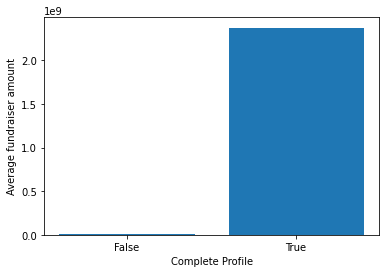

In [511]:
plt.bar(["False", "True"], actionable_1["raising_amount"])
plt.xlabel("Complete Profile")
plt.ylabel('Average fundraiser amount')

In [520]:
difference = actionable_1["raising_amount"][1] - actionable_1["raising_amount"][0]
print("Difference in raised amount:", difference)
times = actionable_1["raising_amount"][1] / actionable_1["raising_amount"][0]
print("Completed profile greater by", times, "times non-completed profiles")

Difference in raised amount: 2366605658.404871
Completed profile greater by 388.7811911779186 times non-completed profiles


**On average founders who have a completed profile raise over 380 times more funds than those without completed profiles**

### 2. Founders with complete profile have higher total views 